# SECCION 6

In [6]:
from pathlib import Path
import joblib

# Detecta automáticamente la carpeta 'models' subiendo niveles si es necesario
candidates = [
    Path("models"),
    Path("../models"),
    Path("../../models"),
]

MODELS = None
for p in candidates:
    if p.exists() and p.is_dir():
        MODELS = p.resolve()
        break

if MODELS is None:
    raise FileNotFoundError("No encontré la carpeta 'models' en: " +
                            ", ".join(str(p) for p in candidates))

print("Usando carpeta models:", MODELS)

# Carga de artefactos
model_path = MODELS / "xgb_best.joblib"
prep_path  = MODELS / "preprocessor.joblib"

print("Model path:", model_path)
print("Preprocessor path:", prep_path)

model = joblib.load(model_path)
preprocessor = joblib.load(prep_path)
print("✓ Artefactos cargados.")


Usando carpeta models: C:\Users\juana\MLOPS\miniproyecto6\models
Model path: C:\Users\juana\MLOPS\miniproyecto6\models\xgb_best.joblib
Preprocessor path: C:\Users\juana\MLOPS\miniproyecto6\models\preprocessor.joblib
✓ Artefactos cargados.



== Métricas en TEST ==

              precision    recall  f1-score   support

           0      0.887     0.786     0.834      1035
           1      0.550     0.722     0.624       374

    accuracy                          0.769      1409
   macro avg      0.718     0.754     0.729      1409
weighted avg      0.797     0.769     0.778      1409

ROC-AUC: 0.8397
clf.classes_: [0 1]
índice clase Churn=1 en predict_proba: 1


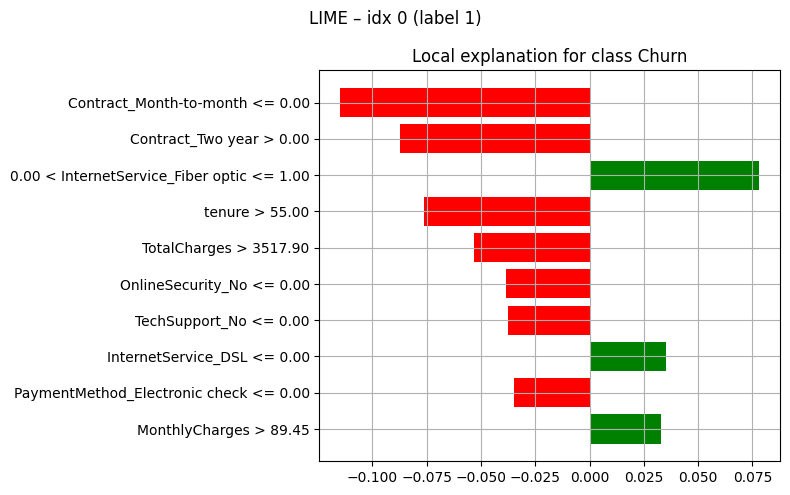

✓ LIME guardado en: c:\Users\juana\MLOPS\miniproyecto6\docs\assets\figuras\lime_idx_0_label1.png


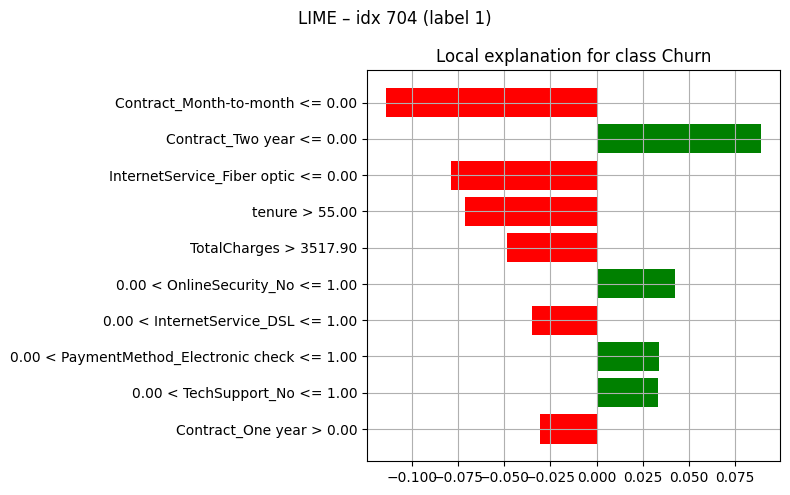

✓ LIME guardado en: c:\Users\juana\MLOPS\miniproyecto6\docs\assets\figuras\lime_idx_704_label1.png


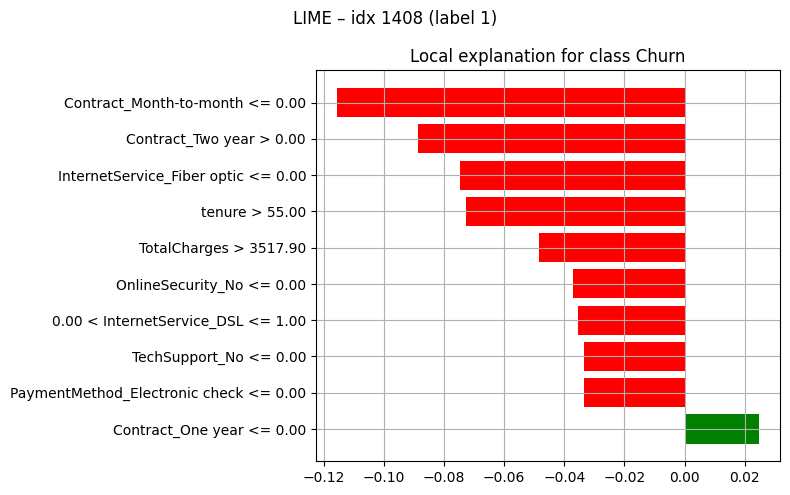

✓ LIME guardado en: c:\Users\juana\MLOPS\miniproyecto6\docs\assets\figuras\lime_idx_1408_label1.png


In [18]:
from sklearn.pipeline import Pipeline

# --- Detectar si el modelo es un Pipeline y extraer el clasificador final ---
is_pipeline = isinstance(model, Pipeline)
clf = model[-1] if is_pipeline else model  # último step del pipeline o el modelo directo

# -------------------------------------------------------------------
# 5) Métricas rápidas para comprobar consistencia (según sea pipeline o no)
# -------------------------------------------------------------------
if hasattr(model, "predict_proba"):
    if is_pipeline:
        # El pipeline ya contiene el preprocessor, pásale X crudo (columnas originales)
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # Modelo "puro": pásale las features ya transformadas
        y_prob = model.predict_proba(X_test_transformed)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
else:
    if is_pipeline:
        y_pred = model.predict(X_test)
    else:
        y_pred = clf.predict(X_test_transformed)
    y_prob = None

try:
    from sklearn.metrics import classification_report, roc_auc_score
    print("\n== Métricas en TEST ==\n")
    print(classification_report(y_test_raw, y_pred, digits=3))
    if y_prob is not None:
        print(f"ROC-AUC: {roc_auc_score(y_test_raw, y_prob):.4f}")
except Exception as e:
    print("Aviso al calcular métricas:", e)

# -------------------------------------------------------------------
# 6) Inicializar LIME sobre el ESPACIO DEL MODELO (numérico)
#    - Entrenamos LIME con X_test_transformed (numérico)
#    - Usamos predict_fn del CLASIFICADOR FINAL (no del pipeline completo)
# -------------------------------------------------------------------
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=np.array(X_test_transformed),
    feature_names=feature_names,
    class_names=["No_Churn", "Churn"],
    mode="classification",
    discretize_continuous=True
)

def predict_proba_fn(x):
    # x llega en espacio transformado -> usar SIEMPRE el clasificador final
    return clf.predict_proba(x)

# Sanity check de clases del clasificador final
print("clf.classes_:", getattr(clf, "classes_", "N/A"))
try:
    pos_idx = int(np.where(clf.classes_ == 1)[0][0])  # índice de la clase '1'
except Exception:
    pos_idx = 1  # fallback
print("índice clase Churn=1 en predict_proba:", pos_idx)

def predict_proba_fn(x):
    # asegurar float y shape (n,2)
    proba = clf.predict_proba(x)
    return np.asarray(proba, dtype=float)

# Pide 2 etiquetas a LIME y selecciona una segura al graficar
indices = [0, len(X_test_transformed)//2, len(X_test_transformed)-1]
for idx in indices:
    exp = explainer.explain_instance(
        data_row=X_test_transformed[idx],
        predict_fn=predict_proba_fn,
        num_features=10,
        top_labels=2  # <- importante: pedir ambas
    )
    # intenta graficar la clase 1; si no existe, usa la disponible
    labels_avail = exp.available_labels()
    label_to_use = 1 if 1 in labels_avail else labels_avail[0]

    fig = exp.as_pyplot_figure(label=label_to_use)
    fig.suptitle(f"LIME – idx {idx} (label {label_to_use})", fontsize=12)
    out_file = FIG_OUT / f"lime_idx_{idx}_label{label_to_use}.png"
    plt.tight_layout()
    plt.savefig(out_file, dpi=120, bbox_inches="tight")
    plt.show()
    print(f"✓ LIME guardado en: {out_file}")


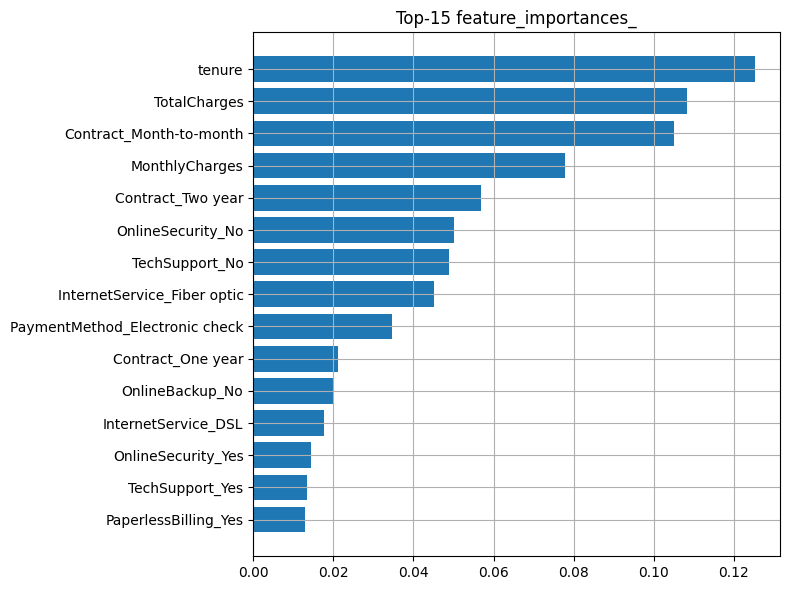

✓ Guardado: docs\assets\figuras\imp_feature_importances_top15.png


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

FIG_OUT = Path("docs/assets/figuras"); FIG_OUT.mkdir(parents=True, exist_ok=True)

# Nombres de features post-preprocesamiento
feat_names = preprocessor.get_feature_names_out()

# Soporta RF/XGB/LGBM (modelos con atributo feature_importances_)
imp = getattr(clf, "feature_importances_", None)
if imp is not None:
    imp_df = (pd.DataFrame({"feature": feat_names, "importance": imp})
                .sort_values("importance", ascending=False)
                .head(15))
    plt.figure(figsize=(8,6))
    plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
    plt.title("Top-15 feature_importances_")
    plt.tight_layout()
    out = FIG_OUT/"imp_feature_importances_top15.png"
    plt.savefig(out, dpi=120, bbox_inches="tight"); plt.show()
    print("✓ Guardado:", out)
else:
    print("El modelo no expone feature_importances_. (Omite esta celda o usa Permutation Importance)")


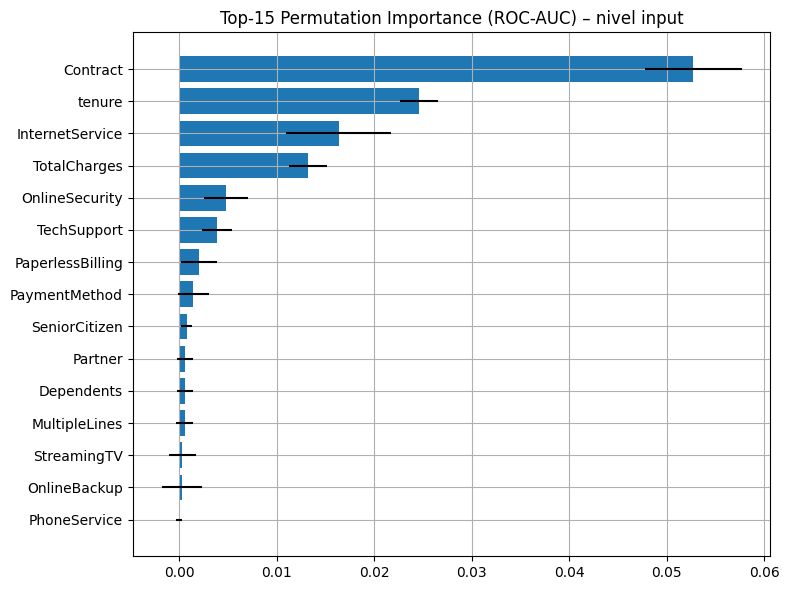

✓ Guardado: docs\assets\figuras\imp_permutation_input_top15.png


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

FIG_OUT = Path("docs/assets/figuras"); FIG_OUT.mkdir(parents=True, exist_ok=True)

pipe = Pipeline([("pre", preprocessor), ("clf", clf)])

res = permutation_importance(
    pipe,              # pipeline completo
    X_test, y_test,    # columnas crudas
    n_repeats=10,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)

# >>> NOMBRES CORRECTOS: columnas crudas (no las transformadas)
feat_names_in = X_test.columns.to_list()

# Sanity check para evitar mismatches
assert len(feat_names_in) == len(res.importances_mean), \
    f"len(names)={len(feat_names_in)} vs len(imp)={len(res.importances_mean)}"

perm_df = (
    pd.DataFrame({
        "feature": feat_names_in,
        "mean_importance": res.importances_mean,
        "std_importance":  res.importances_std
    })
    .sort_values("mean_importance", ascending=False)
    .head(15)
)

plt.figure(figsize=(8,6))
plt.barh(perm_df["feature"][::-1], perm_df["mean_importance"][::-1],
         xerr=perm_df["std_importance"][::-1])
plt.title("Top-15 Permutation Importance (ROC-AUC) – nivel input")
plt.tight_layout()
out = FIG_OUT / "imp_permutation_input_top15.png"
plt.savefig(out, dpi=120, bbox_inches="tight"); plt.show()
print("✓ Guardado:", out)


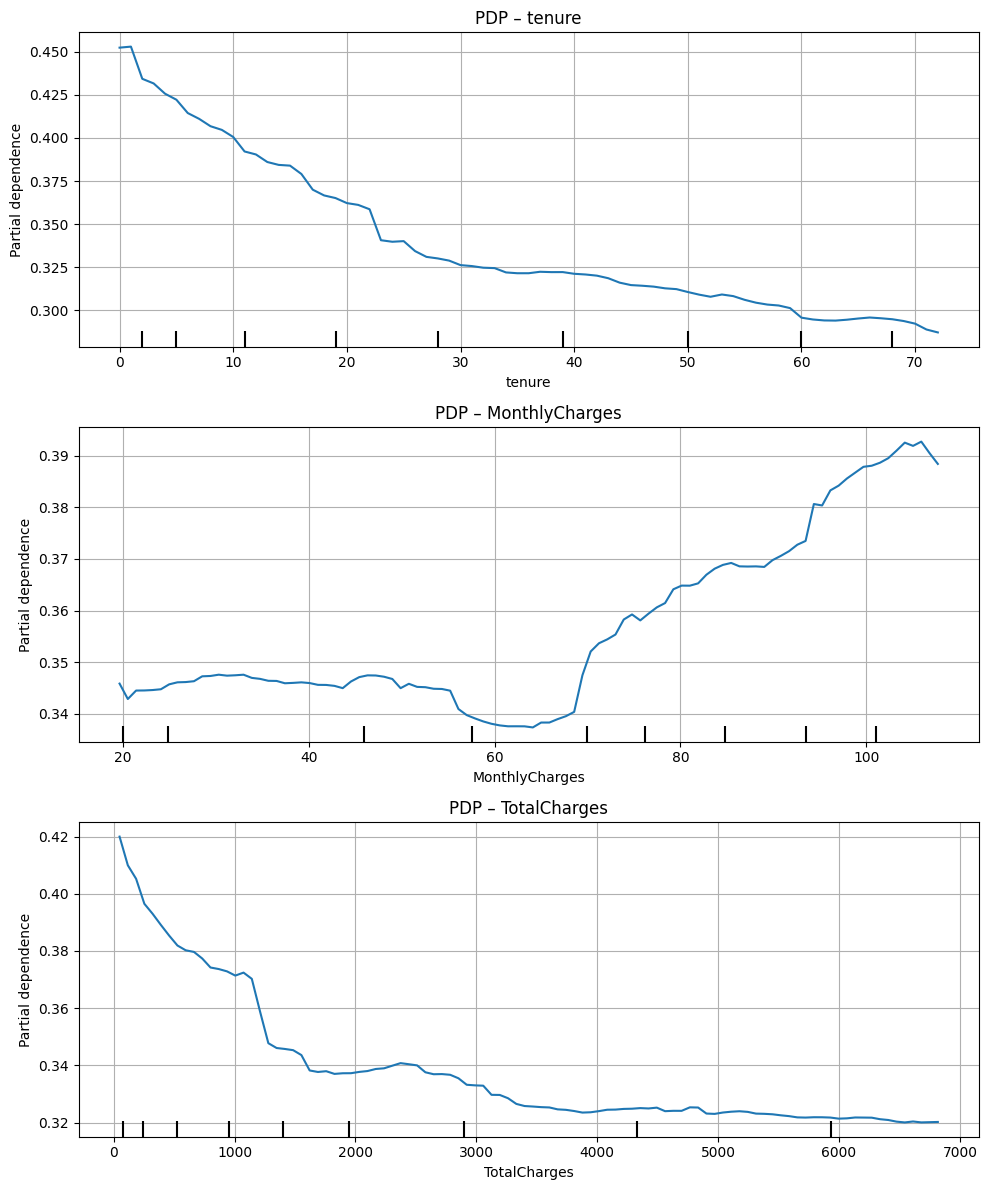

✓ Guardado: docs\assets\figuras\pdp_selected.png


In [26]:
from sklearn.inspection import PartialDependenceDisplay as PDP

pipe = Pipeline([("pre", preprocessor), ("clf", clf)])

features_pdp = []
for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    if col in X_test.columns:
        features_pdp.append(col)

if features_pdp:
    fig = plt.figure(figsize=(10, 4*len(features_pdp)))
    for i, col in enumerate(features_pdp, 1):
        ax = plt.subplot(len(features_pdp), 1, i)
        PDP.from_estimator(pipe, X_test, [col], ax=ax, kind="average")
        ax.set_title(f"PDP – {col}")
    plt.tight_layout()
    out = FIG_OUT/"pdp_selected.png"
    plt.savefig(out, dpi=120, bbox_inches="tight"); plt.show()
    print("✓ Guardado:", out)
else:
    print("No se encontraron las columnas numéricas sugeridas para PDP.")



<Figure size 800x600 with 0 Axes>

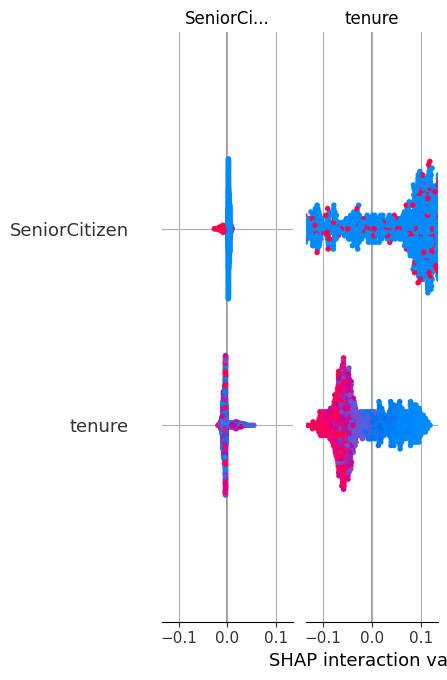

✓ Guardado: docs\assets\figuras\shap_beeswarm.png


In [28]:
import shap, numpy as np

# Muestra para velocidad
idx = np.random.RandomState(42).choice(len(X_test), size=min(1000, len(X_test)), replace=False)
X_sample = X_test.iloc[idx]

pipe = Pipeline([("pre", preprocessor), ("clf", clf)])
X_sample_tr = pipe.named_steps["pre"].transform(X_sample)
feat_names = pipe.named_steps["pre"].get_feature_names_out()

try:
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_sample_tr)
    plt.figure(figsize=(8,6))
    try:
        shap.summary_plot(shap_values, features=X_sample_tr, feature_names=feat_names, show=False)
    except Exception:
        # Si devuelve lista por clase, toma la positiva (1) si existe
        shap.summary_plot(shap_values[1] if isinstance(shap_values, list) else shap_values,
                          features=X_sample_tr, feature_names=feat_names, show=False)
    out = FIG_OUT/"shap_beeswarm.png"
    plt.savefig(out, dpi=120, bbox_inches="tight"); plt.show()
    print("✓ Guardado:", out)
except Exception as e:
    print("SHAP TreeExplainer no disponible para este estimador:", e)


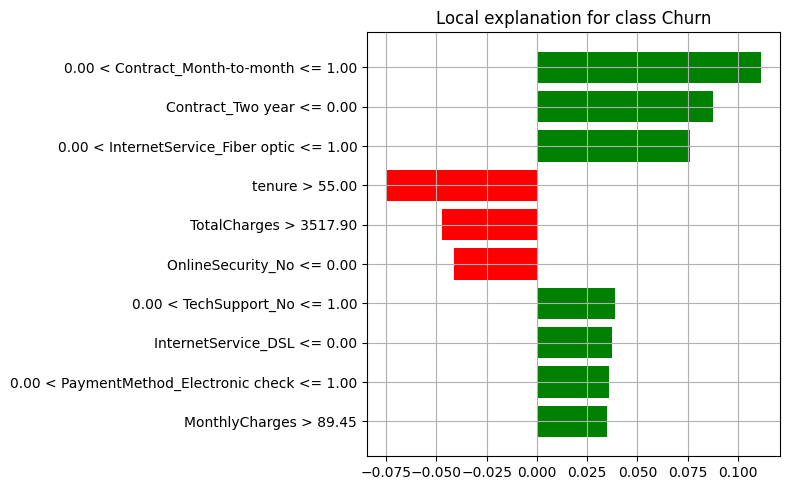

In [30]:
from lime.lime_tabular import LimeTabularExplainer

# nombres y datos transformados
feature_names = preprocessor.get_feature_names_out()
X_test_transformed = preprocessor.transform(X_test)

# ¡explainer de LIME, no SHAP!
lime_explainer = LimeTabularExplainer(
    training_data=X_test_transformed,
    feature_names=feature_names,
    class_names=["No_Churn", "Churn"],
    mode="classification",
    discretize_continuous=True
)

# función de predicción
def predict_proba_fn(x):
    return clf.predict_proba(x)

idx = 10  # ejemplo
exp_row = lime_explainer.explain_instance(
    X_test_transformed[idx],
    predict_proba_fn,
    num_features=10,
    top_labels=2
)

# visualizar / guardar figura
import matplotlib.pyplot as plt
fig = exp_row.as_pyplot_figure(label=1)  # clase positiva
plt.tight_layout()
plt.show()

